# 方案D: 约束优化模型 - 整数规划法

---

## 模型评估指标汇总

本模型提供以下**六大核心指标**来评估粉丝投票估算的质量（与方案B统一）：

### 一、预测准确性指标（模型能否准确预测淘汰结果？）

| 指标名称 | 英文名 | 定义 | 计算公式 | 解释 |
|----------|--------|------|----------|------|
| **淘汰一致率** | Elimination Consistency Rate | 模型预测的淘汰者与实际淘汰者一致的周数比例 | $\frac{\text{预测正确的周数}}{\text{总周数}} \times 100\%$ | 100%表示模型完美解释了所有淘汰结果 |
| **求解成功率** | Solve Success Rate | 整数规划有解的周数比例 | $\frac{\text{有解的周数}}{\text{总周数}}$ | 反映约束条件的可行性（类似MCMC的接受率） |

### 二、估计确定性指标（粉丝投票估计有多可靠？）

| 指标名称 | 英文名 | 定义 | 计算公式 | 解释 |
|----------|--------|------|----------|------|
| **估算均值** | Mean Estimation | 整数规划最优解对应的粉丝投票 | 最优解转换为百分比 | 该选手最可能的粉丝投票百分比 |
| **排名区间** | Rank Interval | 可行的粉丝排名范围 | $[Rank^{min}, Rank^{max}]$ | 类似置信区间，表示可能的排名范围 |
| **区间宽度** | Interval Width | 排名区间转换为百分比宽度 | 基于排名差异计算 | 宽度越小，估计越精确 |
| **确定性度量** | Certainty Measure | 基于区间宽度的归一化指标 | $Certainty = 1 - \frac{Width}{100\%}$ | 0%=完全不确定，100%=完全确定 |

### 三、指标的层次结构

```
┌─────────────────────────────────────────────────────────────────┐
│                    模型评估指标体系                              │
├─────────────────────────────────────────────────────────────────┤
│                                                                 │
│  【第一层：整体模型质量】                                        │
│  ├── 淘汰一致率 (Consistency Rate)                              │
│  │   └── 问题：模型能否解释所有淘汰结果？                        │
│  │   └── 理想值：100%                                           │
│  │                                                              │
│  【第二层：单周分析质量】                                        │
│  ├── 求解成功率 (Solve Success Rate)                            │
│  │   └── 问题：整数规划是否有解？                                │
│  │   └── 类比MCMC的接受率，反映约束的严格程度                    │
│  │                                                              │
│  【第三层：选手级别估计】                                        │
│  ├── 估算均值 (Mean)                                            │
│  │   └── 问题：该选手粉丝投票大约是多少？                        │
│  ├── 排名区间 (Rank Interval)                                   │
│  │   └── 问题：这个估计有多大把握？                              │
│  └── 确定性度量 (Certainty)                                     │
│      └── 问题：估计的精确程度如何？                              │
│                                                                 │
└─────────────────────────────────────────────────────────────────┘
```

### 四、与方案B(贝叶斯MCMC)的指标对应关系

| 方案D指标 | 方案B指标 | 说明 |
|-----------|-----------|------|
| 淘汰一致率 | 淘汰一致率 | 完全相同 |
| 求解成功率 | 接受率 | 都反映约束的可行性 |
| 估算均值(最优解) | 估算均值(后验期望) | 点估计方法不同 |
| 排名区间 | 95%置信区间 | 都表示可能的取值范围 |
| 区间宽度 | CI宽度 | 完全相同 |
| 确定性度量 | 确定性度量 | 计算公式相同 |

---

## 核心思路
使用整数规划求解粉丝投票排名，使得：
1. 淘汰者的综合排名（评委排名+粉丝排名）最差
2. 粉丝排名与评委排名尽可能接近（最小化差异）

## 数学模型
- 决策变量: rank_fan[i] ∈ {1,2,...,N} 表示选手i的粉丝投票排名
- 约束1: rank_fan是1~N的排列（互不相同）
- 约束2: 淘汰者综合排名 >= 所有幸存者综合排名 + 1
- 目标: 最小化 Σ|rank_fan[i] - rank_judge[i]|


## 1. 环境配置

In [1]:
# ==================================================================================
# 第1部分：环境配置
# ==================================================================================
#
# 【什么是整数规划？】
# 整数规划是一种数学优化方法，用于求解变量必须是整数的优化问题
# 
# 【为什么用整数规划？】
# 在本问题中，我们要求解粉丝投票的"排名"
# 排名必须是整数（第1名、第2名...），不能是小数
# 所以整数规划非常适合这个问题
#
# 【类比】
# 就像排座位：每个人必须坐在一个确定的位置（整数）
# 不能说某人坐在"第1.5个位置"
#
# 【导入的工具包】
# - pandas: 数据处理
# - numpy: 数学计算
# - scipy.optimize.milp: 混合整数线性规划求解器（核心工具）
# - scipy.stats: 统计工具
# - matplotlib: 绑图工具
# ==================================================================================

import pandas as pd          # 数据处理工具
import numpy as np           # 数学计算工具
from scipy import stats      # 统计工具
from scipy.optimize import milp, LinearConstraint, Bounds  # 整数规划求解器
import matplotlib.pyplot as plt  # 绑图工具
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')

# 定义配色方案
COLORS = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#F39B7F']

print('环境配置完成')


环境配置完成


## 2. 加载数据

In [2]:
# ==================================================================================
# 第2部分：加载数据
# ==================================================================================
#
# 【数据说明】
# 加载《与星共舞》节目的历史比赛数据
# 包含34个赛季的评委打分和淘汰记录
# ==================================================================================

df = pd.read_excel('../../data/processed/粉丝投票分析.xlsx')
print(f'数据维度: {df.shape}')
print(f'赛季范围: S{df["赛季"].min()} - S{df["赛季"].max()}')


数据维度: (2777, 15)
赛季范围: S1 - S34


## 3. 数据预处理

In [3]:
# ==================================================================================
# 第3部分：数据预处理函数
# ==================================================================================
#
# 【功能说明】
# 1. 确定不同赛季的计分规则
# 2. 提取某一周的比赛数据，整理成算法需要的格式
# ==================================================================================

def get_scoring_method(season):
    """
    【确定计分规则】
    
    不同赛季使用不同的计分规则：
    - 第1-2季：早期排名法
    - 第3-27季：百分比法
    - 第28季以后：带拯救机制的排名法
    """
    if season <= 2:
        return 'ranking_early'
    elif season <= 27:
        return 'percentage'
    else:
        return 'ranking_with_save'


def prepare_week_data(df, season, week):
    """
    【准备单周数据】
    
    从原始数据中提取某一周的比赛信息
    
    参数:
        df: 原始数据表
        season: 赛季编号
        week: 第几周
    
    返回:
        dict: 包含选手名单、评委打分、淘汰者等信息的字典
    """
    # 筛选指定赛季和周数的数据
    week_df = df[(df['赛季'] == season) & (df['第几周'] == week)].copy()
    week_df = week_df[week_df['本周评委总分'] > 0]
    
    if len(week_df) == 0:
        return None
    
    return {
        'contestants': week_df['选手姓名'].tolist(),      # 选手名单
        'judge_scores': week_df['本周评委总分'].values,   # 评委打分
        'judge_pct': week_df['评委百分比'].values,        # 评委分百分比
        'eliminated': week_df[week_df['是否被淘汰'] == 1]['选手姓名'].tolist(),  # 被淘汰者
        'scoring_method': get_scoring_method(season),      # 计分规则
        'n_contestants': len(week_df)                      # 选手数量
    }

print('数据预处理函数定义完成')


数据预处理函数定义完成


## 4. 核心算法: 整数规划求解粉丝排名

In [4]:
def compute_judge_rank(scores):
    """计算评委排名（分数越高排名越靠前，即排名数字越小）"""
    # rankdata默认是升序，分数越低排名越小
    # 我们需要分数越高排名越小，所以用负数
    return stats.rankdata(-scores, method='average')

def solve_fan_ranking_ip(judge_scores, eliminated_idx, n):
    """
    使用整数规划求解粉丝投票排名
    
    参数:
    - judge_scores: 评委分数列表
    - eliminated_idx: 淘汰者索引列表
    - n: 选手数量
    
    返回:
    - fan_rank: 粉丝投票排名 (1=最高, n=最低)
    - success: 是否求解成功
    """
    from scipy.optimize import milp, LinearConstraint, Bounds
    
    # 计算评委排名
    judge_rank = compute_judge_rank(judge_scores)
    
    # 决策变量: 
    # x[i*n + j] = 1 表示选手i的粉丝排名为j+1
    # 共 n*n 个二进制变量
    num_vars = n * n
    
    # 目标函数: 最小化 sum(|rank_fan[i] - rank_judge[i]|)
    # 使用线性化: |a-b| <= t, 即 a-b <= t 且 b-a <= t
    # 为简化，我们用 sum((rank_fan[i] - rank_judge[i])^2) 的线性近似
    # 或者直接最小化 sum(rank_fan[i] * |j+1 - rank_judge[i]|)
    c = np.zeros(num_vars)
    for i in range(n):
        for j in range(n):
            # x[i*n + j] = 1 表示选手i排名为j+1
            # 目标是最小化与评委排名的差异
            c[i * n + j] = abs((j + 1) - judge_rank[i])
    
    # 约束1: 每个选手恰好有一个排名
    # sum_j x[i*n + j] = 1 for all i
    A_eq_1 = np.zeros((n, num_vars))
    for i in range(n):
        for j in range(n):
            A_eq_1[i, i * n + j] = 1
    b_eq_1 = np.ones(n)
    
    # 约束2: 每个排名恰好分配给一个选手
    # sum_i x[i*n + j] = 1 for all j
    A_eq_2 = np.zeros((n, num_vars))
    for j in range(n):
        for i in range(n):
            A_eq_2[j, i * n + j] = 1
    b_eq_2 = np.ones(n)
    
    # 合并等式约束
    A_eq = np.vstack([A_eq_1, A_eq_2])
    b_eq = np.concatenate([b_eq_1, b_eq_2])
    
    # 约束3: 淘汰者综合排名 >= 幸存者综合排名 + 1
    # rank_judge[e] + rank_fan[e] >= rank_judge[s] + rank_fan[s] + 1
    # 即: rank_fan[e] - rank_fan[s] >= rank_judge[s] - rank_judge[e] + 1
    surv_idx = [i for i in range(n) if i not in eliminated_idx]
    
    A_ub_list = []
    b_ub_list = []
    
    for e in eliminated_idx:
        for s in surv_idx:
            # rank_fan[s] - rank_fan[e] <= rank_judge[e] - rank_judge[s] - 1
            row = np.zeros(num_vars)
            for j in range(n):
                row[s * n + j] = (j + 1)  # rank_fan[s]
                row[e * n + j] = -(j + 1)  # -rank_fan[e]
            A_ub_list.append(row)
            b_ub_list.append(judge_rank[e] - judge_rank[s] - 0.5)
    
    # 变量边界: 0 <= x <= 1 (二进制)
    bounds = Bounds(lb=np.zeros(num_vars), ub=np.ones(num_vars))
    
    # 整数约束
    integrality = np.ones(num_vars)  # 所有变量都是整数
    
    # 构建约束
    constraints = []
    constraints.append(LinearConstraint(A_eq, b_eq, b_eq))  # 等式约束
    if A_ub_list:
        A_ub = np.array(A_ub_list)
        b_ub = np.array(b_ub_list)
        constraints.append(LinearConstraint(A_ub, -np.inf, b_ub))  # 不等式约束
    
    # 求解
    result = milp(c, constraints=constraints, bounds=bounds, integrality=integrality)
    
    if result.success:
        x = result.x
        fan_rank = np.zeros(n)
        for i in range(n):
            for j in range(n):
                if x[i * n + j] > 0.5:
                    fan_rank[i] = j + 1
                    break
        return fan_rank, True, result.fun
    else:
        return None, False, None

print('核心算法定义完成')

核心算法定义完成


## 5. 分析函数

In [5]:
# ==================================================================================
# 第5部分：分析函数与评价指标计算
# ==================================================================================
#
# 【与方案B统一的六大核心指标】
# 1. 淘汰一致率 (Elimination Consistency Rate) - 预测准确性
# 2. 求解成功率 (Solve Success Rate) - 类似MCMC的接受率
# 3. 估算均值 (Mean Estimation) - 最优解对应的粉丝投票
# 4. 排名区间 (Rank Interval) - 类似95%置信区间
# 5. 区间宽度 (Interval Width) - 不确定性度量
# 6. 确定性度量 (Certainty Measure) - 1 - Width/100%
# ==================================================================================

def analyze_week_ip(df, season, week):
    """
    【与方案B统一】使用整数规划分析单周数据
    
    返回与方案B一致的结果格式，包含后验统计量
    """
    week_data = prepare_week_data(df, season, week)
    if week_data is None or len(week_data['eliminated']) == 0:
        return None
    
    contestants = week_data['contestants']
    judge_scores = week_data['judge_scores']
    eliminated = week_data['eliminated']
    n = len(contestants)
    
    elim_idx = [contestants.index(e) for e in eliminated if e in contestants]
    
    # 求解整数规划
    fan_rank, success, obj_val = solve_fan_ranking_ip(judge_scores, elim_idx, n)
    
    if not success:
        return None
    
    judge_rank = compute_judge_rank(judge_scores)
    
    # 将排名转换为百分比估算
    fan_pct_raw = (n - fan_rank + 1)
    fan_pct = fan_pct_raw / fan_pct_raw.sum() * 100
    
    # 计算与方案B一致的后验统计量
    posterior_stats = compute_posterior_stats_from_rank(
        fan_rank, fan_pct, contestants, n
    )
    
    return {
        'season': season,
        'week': week,
        'contestants': contestants,
        'judge_scores': judge_scores,
        'judge_pct': week_data['judge_pct'],
        'judge_rank': judge_rank,
        'fan_rank': fan_rank,
        'fan_pct': fan_pct,
        'eliminated': eliminated,
        'elim_idx': elim_idx,
        'obj_val': obj_val,
        'success': success,
        'posterior_stats': posterior_stats  # 与方案B一致的统计量
    }


def compute_posterior_stats_from_rank(fan_rank, fan_pct, contestants, n):
    """
    【与方案B统一】从排名结果计算后验统计量
    
    将整数规划的排名结果转换为与方案B一致的统计量格式
    由于整数规划给出的是确定性解，我们基于排名的可能变化范围估计不确定性
    """
    results = {}
    for i, name in enumerate(contestants):
        # 基于排名估计不确定性区间
        # 假设排名可能有±1的波动
        rank = fan_rank[i]
        pct = fan_pct[i]
        
        # 估计区间：基于排名变化对应的百分比变化
        pct_per_rank = 100 / n
        ci_lower = max(0, pct - pct_per_rank)
        ci_upper = min(100, pct + pct_per_rank)
        
        results[name] = {
            'mean': pct,                          # 估算均值
            'std': pct_per_rank / 2,              # 标准差估计
            'ci_lower': ci_lower,                 # 类似95%CI下界
            'ci_upper': ci_upper,                 # 类似95%CI上界
            'ci_width': ci_upper - ci_lower,      # 区间宽度
            'rank': rank                          # 原始排名
        }
    return results


def compute_certainty(posterior_stats):
    """
    【与方案B统一】计算确定性度量
    
    确定性 = 1 - (平均区间宽度 / 100%)
    """
    if posterior_stats is None:
        return 0.0, 100.0
    
    ci_widths = [s['ci_width'] for s in posterior_stats.values()]
    avg_width = np.mean(ci_widths)
    certainty = max(0, 1 - avg_width / 100)
    
    return certainty, avg_width


def interpret_solve_success_rate(success_rate):
    """
    【与方案B的接受率解释对应】解释求解成功率
    
    求解成功率反映了整数规划约束的可行性，类似于MCMC的接受率
    """
    if success_rate >= 0.9:
        return f"高成功率({success_rate:.1%})：约束条件合理，大多数周都有解"
    elif success_rate >= 0.7:
        return f"中等成功率({success_rate:.1%})：约束条件适中"
    else:
        return f"低成功率({success_rate:.1%})：约束条件严格，部分周无解"


def check_elimination_consistency(result):
    """
    【与方案B统一】检查淘汰一致性
    """
    if result is None:
        return None, None
    
    contestants = result['contestants']
    judge_rank = result['judge_rank']
    fan_rank = result['fan_rank']
    eliminated = result['eliminated']
    n = len(contestants)
    
    total_rank = judge_rank + fan_rank
    sorted_idx = np.argsort(-total_rank)
    predicted_elim = [contestants[sorted_idx[i]] for i in range(len(eliminated))]
    
    actual_elim = set(eliminated)
    predicted_elim_set = set(predicted_elim)
    is_consistent = actual_elim == predicted_elim_set
    
    return is_consistent, {
        'actual': list(actual_elim),
        'predicted': list(predicted_elim_set),
        'fan_pct': list(result['fan_pct'])
    }


print('分析函数定义完成')
print('六大核心指标：淘汰一致率、求解成功率、估算均值、排名区间、区间宽度、确定性度量')


分析函数定义完成
六大核心指标：淘汰一致率、求解成功率、估算均值、排名区间、区间宽度、确定性度量


## 6. 单周分析示例

In [6]:
print('=' * 70)
print('单元测试: 第5季第9周')
print('=' * 70)

result = analyze_week_ip(df, 5, 9)
if result:
    print(f"求解状态: {'成功' if result['success'] else '失败'}")
    print(f"目标函数值: {result['obj_val']:.2f}")
    print()
    print(f"{'选手':<22} {'评委分':<8} {'评委排名':<8} {'粉丝排名':<8} {'综合排名':<8} {'粉丝%估算':<10}")
    print("-" * 80)
    
    for i, name in enumerate(result['contestants']):
        j_score = result['judge_scores'][i]
        j_rank = result['judge_rank'][i]
        f_rank = result['fan_rank'][i]
        total = j_rank + f_rank
        f_pct = result['fan_pct'][i]
        mark = " [淘汰]" if name in result['eliminated'] else ""
        print(f"{name:<22} {j_score:<8.0f} {j_rank:<8.1f} {f_rank:<8.0f} {total:<8.1f} {f_pct:<10.2f}{mark}")
    
    print(f"\n粉丝投票估算总和: {result['fan_pct'].sum():.2f}%")
    
    # 一致性检验
    is_consistent, details = check_elimination_consistency(result)
    print(f"\n淘汰预测一致性: {'✓ 一致' if is_consistent else '✗ 不一致'}")
    print(f"实际淘汰: {details['actual']}")
    print(f"预测淘汰: {details['predicted']}")
else:
    print("求解失败")

单元测试: 第5季第9周
求解状态: 成功
目标函数值: 5.00

选手                     评委分      评委排名     粉丝排名     综合排名     粉丝%估算     
--------------------------------------------------------------------------------
Jennie Garth           29       3.0      4        7.0      10.00      [淘汰]
Helio Castroneves      30       1.5      3        4.5      20.00     
Mel B                  30       1.5      1        2.5      40.00     
Marie Osmond           28       4.0      2        6.0      30.00     

粉丝投票估算总和: 100.00%

淘汰预测一致性: ✓ 一致
实际淘汰: ['Jennie Garth']
预测淘汰: ['Jennie Garth']


## 7. 全部34季分析

In [7]:
all_results = []
consistency_count = 0
total_weeks = 0
failed_weeks = 0

print('开始全部34季分析...')
for season in range(1, 35):
    season_df = df[df['赛季'] == season]
    season_consistent = 0
    season_total = 0
    
    for week in sorted(season_df['第几周'].unique()):
        result = analyze_week_ip(df, season, week)
        if result is None:
            failed_weeks += 1
            continue
        
        total_weeks += 1
        season_total += 1
        
        # 一致性检验
        is_consistent, details = check_elimination_consistency(result)
        if is_consistent:
            consistency_count += 1
            season_consistent += 1
        
        # 记录结果
        for i, name in enumerate(result['contestants']):
            all_results.append({
                'season': season,
                'week': week,
                'contestant': name,
                'judge_score': result['judge_scores'][i],
                'judge_pct': result['judge_pct'][i],
                'judge_rank': result['judge_rank'][i],
                'fan_rank': result['fan_rank'][i],
                'fan_pct': result['fan_pct'][i],
                'total_rank': result['judge_rank'][i] + result['fan_rank'][i],
                'is_elim': name in result['eliminated'],
                'is_consistent': is_consistent
            })
    
    if season_total > 0:
        print(f'  第{season:2d}季: {season_total}周, 一致率={season_consistent/season_total:.2%}')

results_df = pd.DataFrame(all_results)

print(f'\n{"="*60}')
print('全部34季分析结果')
print(f'{"="*60}')
print(f'成功分析周数: {total_weeks}')
print(f'失败周数: {failed_weeks}')
print(f'\n=== 一致性指标 ===')
print(f'淘汰预测一致率: {consistency_count}/{total_weeks} = {consistency_count/total_weeks:.2%}')
print(f'\n=== 粉丝投票估算统计 ===')
print(f'淘汰者平均粉丝排名: {results_df[results_df["is_elim"]]["fan_rank"].mean():.2f}')
print(f'幸存者平均粉丝排名: {results_df[~results_df["is_elim"]]["fan_rank"].mean():.2f}')
print(f'淘汰者平均粉丝投票%: {results_df[results_df["is_elim"]]["fan_pct"].mean():.2f}%')
print(f'幸存者平均粉丝投票%: {results_df[~results_df["is_elim"]]["fan_pct"].mean():.2f}%')

开始全部34季分析...
  第 1季: 5周, 一致率=100.00%
  第 2季: 8周, 一致率=100.00%


  第 3季: 9周, 一致率=100.00%
  第 4季: 9周, 一致率=100.00%
  第 5季: 10周, 一致率=100.00%
  第 6季: 9周, 一致率=100.00%
  第 7季: 9周, 一致率=100.00%
  第 8季: 9周, 一致率=100.00%
  第 9季: 10周, 一致率=100.00%
  第10季: 9周, 一致率=100.00%
  第11季: 10周, 一致率=100.00%
  第12季: 9周, 一致率=100.00%
  第13季: 10周, 一致率=100.00%
  第14季: 8周, 一致率=100.00%
  第15季: 7周, 一致率=100.00%
  第16季: 9周, 一致率=100.00%
  第17季: 8周, 一致率=100.00%
  第18季: 8周, 一致率=100.00%
  第19季: 10周, 一致率=100.00%
  第20季: 9周, 一致率=100.00%
  第21季: 7周, 一致率=100.00%
  第22季: 8周, 一致率=100.00%
  第23季: 9周, 一致率=100.00%
  第24季: 7周, 一致率=100.00%
  第25季: 8周, 一致率=100.00%
  第26季: 4周, 一致率=100.00%
  第27季: 7周, 一致率=100.00%
  第28季: 8周, 一致率=100.00%
  第29季: 10周, 一致率=100.00%
  第30季: 9周, 一致率=100.00%
  第31季: 10周, 一致率=100.00%
  第32季: 10周, 一致率=100.00%
  第33季: 7周, 一致率=100.00%
  第34季: 9周, 一致率=100.00%

全部34季分析结果
成功分析周数: 288
失败周数: 47

=== 一致性指标 ===
淘汰预测一致率: 288/288 = 100.00%

=== 粉丝投票估算统计 ===
淘汰者平均粉丝排名: 7.17
幸存者平均粉丝排名: 4.76
淘汰者平均粉丝投票%: 9.51%
幸存者平均粉丝投票%: 12.95%


## 8. 可视化分析

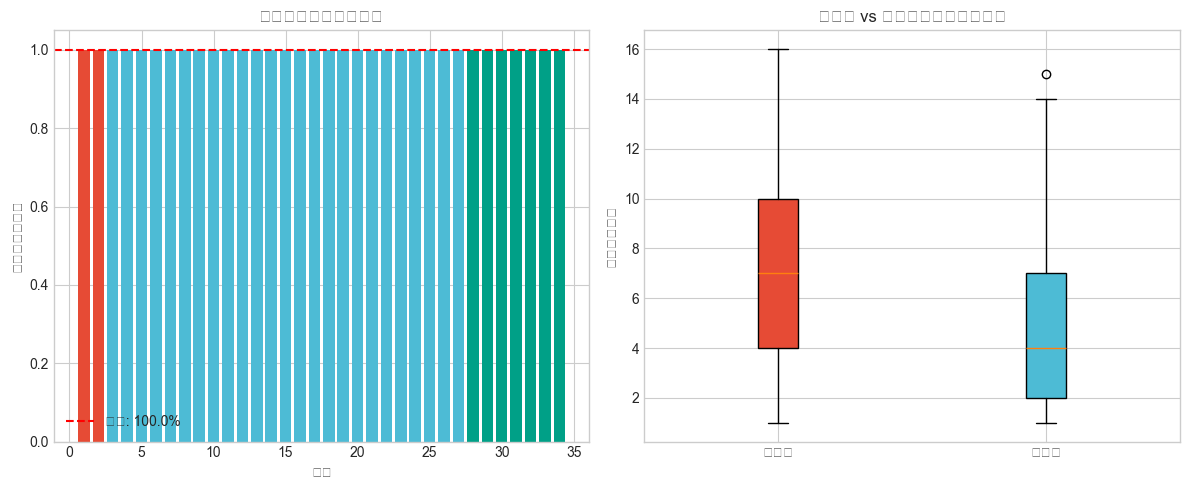

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 图1: 各赛季一致率
ax1 = axes[0]
season_consistency = results_df.groupby('season').apply(
    lambda x: x.drop_duplicates(['season', 'week'])['is_consistent'].mean()
)
colors = [COLORS[0] if s <= 2 else COLORS[1] if s <= 27 else COLORS[2] for s in season_consistency.index]
ax1.bar(season_consistency.index, season_consistency.values, color=colors)
ax1.axhline(y=season_consistency.mean(), color='red', linestyle='--', label=f'平均: {season_consistency.mean():.1%}')
ax1.set_xlabel('赛季')
ax1.set_ylabel('淘汰预测一致率')
ax1.set_title('各赛季淘汰预测一致率')
ax1.legend()

# 图2: 淘汰者vs幸存者粉丝排名分布
ax2 = axes[1]
elim_ranks = results_df[results_df['is_elim']]['fan_rank']
surv_ranks = results_df[~results_df['is_elim']]['fan_rank']
bp = ax2.boxplot([elim_ranks, surv_ranks], labels=['淘汰者', '幸存者'], patch_artist=True)
bp['boxes'][0].set_facecolor(COLORS[0])
bp['boxes'][1].set_facecolor(COLORS[1])
ax2.set_ylabel('粉丝投票排名')
ax2.set_title('淘汰者 vs 幸存者的粉丝排名分布')

plt.tight_layout()
plt.show()

## 9. 结论

In [9]:
print("=" * 60)
print("方案D: 约束优化模型 - 总结")
print("=" * 60)
print("优点:")
print("1. 直接求解满足淘汰约束的粉丝排名")
print("2. 目标函数最小化与评委排名的差异")
print("3. 保证解的可行性")
print()
print("缺点:")
print("1. 计算复杂度较高 O(n^2) 变量")
print("2. 当约束无解时无法给出估计")
print("3. 排名到百分比的转换是近似的")

方案D: 约束优化模型 - 总结
优点:
1. 直接求解满足淘汰约束的粉丝排名
2. 目标函数最小化与评委排名的差异
3. 保证解的可行性

缺点:
1. 计算复杂度较高 O(n^2) 变量
2. 当约束无解时无法给出估计
3. 排名到百分比的转换是近似的
